In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.unfolding_flow import UnfoldingFlow

import numpy as np
#import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from collections import defaultdict
from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak
import random
#import pandas as pd

from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor

pi = torch.pi


In [ ]:
torch.cuda.device_count()

In [7]:
batchSize = 1024
path_data = '/work/adpetre/MEMFlow/scripts/../../dataset/v7/'

device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # specify the GPU ids

basedir_flow = "/work/dvalsecc/MEM/models_archive/flow_pretraining_huber_mmd_labframe_gluon_boostpzscale/preTraining_spanet_labframe_v2-gluon_hiddenFeatures:64_dimFeedForward:512_nheadEnc:8_LayersEnc:4_nheadDec:4_LayersDec:4/"
path_flow = basedir_flow + '/model_flow.pt'
path_to_conf = basedir_flow + "/config_spanet_labframe_v2-gluon.yaml"

with open(path_to_conf) as f:
        conf = OmegaConf.load(path_to_conf)

# model = UnfoldingFlow(model_path=path_flow,
#                     read_CondTransf=False,
#                     log_mean = conf.scaling_params.log_mean,
#                     log_std = conf.scaling_params.log_std,
#                     no_jets=conf.input_shape.number_jets,
#                     no_lept=conf.input_shape.number_lept,
#                     input_features=conf.input_shape.input_features,
#                     cond_hiddenFeatures=conf.conditioning_transformer.hidden_features,
#                     cond_dimFeedForward=conf.conditioning_transformer.dim_feedforward_transformer,
#                     cond_outFeatures=conf.conditioning_transformer.out_features,
#                     cond_nheadEncoder=conf.conditioning_transformer.nhead_encoder,
#                     cond_NoLayersEncoder=conf.conditioning_transformer.no_layers_encoder,
#                     cond_nheadDecoder=conf.conditioning_transformer.nhead_decoder,
#                     cond_NoLayersDecoder=conf.conditioning_transformer.no_layers_decoder,
#                     cond_NoDecoders=conf.conditioning_transformer.no_decoders,
#                     cond_aggregate=conf.conditioning_transformer.aggregate,
#                     use_latent=conf.conditioning_transformer.use_latent,
#                     flow_nfeatures=conf.unfolding_flow.nfeatures,
#                     flow_ncond=conf.unfolding_flow.ncond, 
#                     flow_ntransforms=conf.unfolding_flow.ntransforms,
#                     flow_hiddenMLP_NoLayers=conf.unfolding_flow.hiddenMLP_NoLayers, 
#                     flow_hiddenMLP_LayerDim=conf.unfolding_flow.hiddenMLP_LayerDim,
#                     flow_bins=conf.unfolding_flow.bins,
#                     flow_autoregressive=conf.unfolding_flow.autoregressive,
#                     flow_base=conf.unfolding_flow.base,
#                     flow_base_first_arg=conf.unfolding_flow.base_first_arg,
#                     flow_base_second_arg=conf.unfolding_flow.base_second_arg,
#                     flow_bound=conf.unfolding_flow.bound,
#                     device=device,
#                     dtype=torch.float64).to(device)


# state_dict = torch.load(path_flow)
# model.load_state_dict(state_dict['model_state_dict'])

# # model = torch.nn.DataParallel(model)
# model.to(device)

In [8]:
E_CM = 13000
M_HIGGS = 125.25
M_TOP = 172.5
M_GLUON = 1e-5
phasespace = PhaseSpace(E_CM, [21,21], [25,6,-6,21], final_masses=torch.tensor([M_HIGGS, M_TOP, M_TOP, M_GLUON]))

conf.input_dataset = "/work/dvalsecc/MEM/datasets/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part2"

if (conf.cartesian):
    data = DatasetCombined(conf.input_dataset, dev=device, dtype=torch.float64, build=False,
                                reco_list=['scaledLogRecoParticlesCartesian', 'mask_lepton', 
                                            'mask_jets','mask_met',
                                            'mask_boost', 'data_boost'],
                                parton_list=['phasespace_intermediateParticles_onShell',
                                            'phasespace_rambo_detjacobian_onShell'])
else:
    data = DatasetCombined(conf.input_dataset, dev=device, dtype=torch.float64, build=False,
                                reco_list=['scaledLogRecoParticles', 'mask_lepton', 
                                            'mask_jets','mask_met',
                                            'mask_boost', 'data_boost'],
                                parton_list=['phasespace_intermediateParticles_onShell',
                                            'phasespace_rambo_detjacobian_onShell',
                                             'data_higgs_t_tbar_ISR_cartesian',
                                             'data_boost'
                                            ])

    
# data_loader = DataLoader(dataset=data, shuffle=False, batch_size=256)
# dataCorrect = data.parton_data.data_higgs_t_tbar_ISR_cartesian
# PS_target = data.parton_data.phasespace_intermediateParticles_onShell

# higgsCorrect = vector.array(
#     {
#         "E": dataCorrect[:,0,0].detach().numpy(),
#         "px": dataCorrect[:,0,1].detach().numpy(),
#         "py": dataCorrect[:,0,2].detach().numpy(),
#         "pz": dataCorrect[:,0,3].detach().numpy(),
#     }
# )

# thadCorrect = vector.array(
#     {
#         "E": dataCorrect[:,1,0].detach().numpy(),
#         "px": dataCorrect[:,1,1].detach().numpy(),
#         "py": dataCorrect[:,1,2].detach().numpy(),
#         "pz": dataCorrect[:,1,3].detach().numpy(),
#     }
# )

# tlepCorrect = vector.array(
#     {
#         "E": dataCorrect[:,2,0].detach().numpy(),
#         "px": dataCorrect[:,2,1].detach().numpy(),
#         "py": dataCorrect[:,2,2].detach().numpy(),
#         "pz": dataCorrect[:,2,3].detach().numpy(),
#     }
# )

# glISRCorrect = vector.array(
#     {
#         "E": dataCorrect[:,3,0].detach().numpy(),
#         "px": dataCorrect[:,3,1].detach().numpy(),
#         "py": dataCorrect[:,3,2].detach().numpy(),
#         "pz": dataCorrect[:,3,3].detach().numpy(),
#     }
# )

# higgsCorrect = ak.with_name(higgsCorrect, name="Momentum4D")
# thadCorrect = ak.with_name(thadCorrect, name="Momentum4D")
# tlepCorrect = ak.with_name(tlepCorrect, name="Momentum4D")
# glISRCorrect = ak.with_name(glISRCorrect, name="Momentum4D")

Get data boosted in CM

RecoLevel
Badsedir:  /work/dvalsecc/MEM/datasets/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part2
Reading reco_level Files
Load scaledLogRecoParticles

PartonLevel
Reading parton_level Files
Load phasespace_intermediateParticles_onShell



In [10]:
def plot_var2d(higgs_var1, higgs_var2, thad_var1, thad_var2, tlep_var1, tlep_var2,
             ISR_var1, ISR_var2, name1, name2, nameFig, start1=0, stop1=1000, start2=0, stop2=1000, bins1=100, bins2=100,
             higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, neg_Mask=False, log=False, name='da', nameunit=''):
        
        
        if neg_Mask:
            higgs_mask = np.logical_not(higgs_mask)
            thad_mask = np.logical_not(thad_mask)
            tlep_mask = np.logical_not(tlep_mask)
            ISR_mask = np.logical_not(ISR_mask)

        # Quick construction, no other imports needed:
        hist2d_var_higgs = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_thad = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_tlep = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_ISR = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_higgs.fill(higgs_var1[higgs_mask],
                            higgs_var2[higgs_mask])

        hist2d_var_thad.fill(thad_var1[thad_mask],
                            thad_var2[thad_mask])

        hist2d_var_tlep.fill(tlep_var1[tlep_mask],
                            tlep_var2[tlep_mask])

        hist2d_var_ISR.fill(ISR_var1[ISR_mask],
                            ISR_var2[ISR_mask])

        colormap='viridis'
        my_viridis = mpl.colormaps[colormap].with_extremes(under="white")
        
        fontsize = 20
        labelsize=14
        labels = ['higgs', 'thad', 'tlep', 'ISR']
        hist2d_list = [hist2d_var_higgs, hist2d_var_thad, hist2d_var_tlep, hist2d_var_ISR]
        
        
        fig, axs = plt.subplots(1, 4, figsize=(16, 6))

        if log:
            for i in range(4):
                w, x, y = hist2d_list[i].to_numpy()
                mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, norm=mpl.colors.LogNorm(vmin=1))
                axs[i].set_xlabel(f"{name}-correct {nameunit}", fontsize=fontsize)
                axs[i].set_ylabel(f"{name}-regressed {nameunit}", fontsize=fontsize)
                axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
                cbar = fig.colorbar(mesh)
                cbar.ax.tick_params(labelsize=labelsize)
                plt.tight_layout()

        else:
            for i in range(4):
                w, x, y = hist2d_list[i].to_numpy()
                mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, vmin=1)
                axs[i].set_xlabel(f"{name}-correct {nameunit}", fontsize=fontsize)
                axs[i].set_ylabel(f"{name}-regressed {nameunit}", fontsize=fontsize)
                axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
                cbar = fig.colorbar(mesh)
                cbar.ax.tick_params(labelsize=labelsize)
                plt.tight_layout()

In [11]:
def get_particle_awkward(momenta):
    
    higgs = momenta[:,0]
    thad = momenta[:,1]
    tlep = momenta[:,2]
    ISR = momenta[:,3]
    
    higgs = vector.array(
                {
                "E": higgs[:,0].detach().numpy(),
                "px": higgs[:,1].detach().numpy(),
                "py": higgs[:,2].detach().numpy(),
                "pz": higgs[:,3].detach().numpy()
                }
            )

    thad = vector.array(
                {
                "E": thad[:,0].detach().numpy(),
                "px": thad[:,1].detach().numpy(),
                "py": thad[:,2].detach().numpy(),
                "pz":thad[:,3].detach().numpy(),
                }
            )

    tlep = vector.array(
                {
                "E": tlep[:,0].detach().numpy(),
                "px": tlep[:,1].detach().numpy(),
                "py": tlep[:,2].detach().numpy(),
                "pz": tlep[:,3].detach().numpy(),
                }
            )
    
    ISR = vector.array(
                {
                "E": ISR[:,0].detach().numpy(),
                "px": ISR[:,1].detach().numpy(),
                "py": ISR[:,2].detach().numpy(),
                "pz": ISR[:,3].detach().numpy(),
                }
            )
    
    higgs = ak.with_name(higgs, name="Momentum4D")
    thad = ak.with_name(thad, name="Momentum4D")
    tlep = ak.with_name(tlep, name="Momentum4D")
    ISR = ak.with_name(ISR, name="Momentum4D")
    
    return higgs, thad, tlep, ISR

def get_particle_awkward_samples(momenta):
    
    higgs = momenta[:,:,2]
    thad = momenta[:,:,3]
    tlep = momenta[:,:,4]
    ISR = momenta[:,:,5]
    
    higgs = vector.array(
                {
                "E": higgs[:,:,0].detach().numpy(),
                "px": higgs[:,:,1].detach().numpy(),
                "py": higgs[:,:,2].detach().numpy(),
                "pz": higgs[:,:,3].detach().numpy()
                }
            )

    thad = vector.array(
                {
                "E": thad[:,:,0].detach().numpy(),
                "px": thad[:,:,1].detach().numpy(),
                "py": thad[:,:,2].detach().numpy(),
                "pz":thad[:,:,3].detach().numpy(),
                }
            )

    tlep = vector.array(
                {
                "E": tlep[:,:,0].detach().numpy(),
                "px": tlep[:,:,1].detach().numpy(),
                "py": tlep[:,:,2].detach().numpy(),
                "pz": tlep[:,:,3].detach().numpy(),
                }
            )
    
    ISR = vector.array(
                {
                "E": ISR[:,:,0].detach().numpy(),
                "px": ISR[:,:,1].detach().numpy(),
                "py": ISR[:,:,2].detach().numpy(),
                "pz": ISR[:,:,3].detach().numpy(),
                }
            )
    
    higgs = ak.with_name(higgs, name="Momentum4D")
    thad = ak.with_name(thad, name="Momentum4D")
    tlep = ak.with_name(tlep, name="Momentum4D")
    ISR = ak.with_name(ISR, name="Momentum4D")
    
    return higgs, thad, tlep, ISR



def get_diff(C, C_samples, Nsamples):
    # Diff between target quantity in awkward array and samples of the same quantity
    return torch.from_numpy(ak.to_numpy(C_samples)) - torch.from_numpy(ak.to_numpy(C)).unsqueeze(1).expand(-1, Nsamples)

def get_std(C_samples): 
    return np.nanstd(ak.to_numpy(C_samples), axis=1)

In [12]:
PS = data.parton_data.phasespace_intermediateParticles_onShell

In [13]:
PS_logit = torch.logit(PS)
PS_new = torch.sigmoid(PS_logit)

In [15]:
PS_new[0]

tensor([0.6699, 0.1539, 0.2853, 0.6591, 0.8153, 0.8080, 0.9665, 0.4824, 0.8599,
        0.8333])

In [16]:
PS[0]

tensor([0.6699, 0.1539, 0.2853, 0.6591, 0.8153, 0.8080, 0.9665, 0.4824, 0.8599,
        0.8333])

(array([61219., 42255., 35792., 32003., 29659., 27363., 25873., 24860.,
        23347., 22412., 21442., 21214., 20395., 19950., 19434., 19096.,
        18895., 18097., 18004., 17873., 17488., 17004., 17098., 16516.,
        16611., 16109., 16071., 15936., 15555., 15651., 15277., 15090.,
        15040., 14880., 15017., 14669., 14592., 14528., 14167., 14108.,
        14310., 14121., 13980., 13854., 13870., 13952., 13899., 13776.,
        13804., 13525., 13549., 13763., 13887., 13532., 13459., 13668.,
        13461., 13819., 13550., 13560., 13511., 13598., 13669., 13479.,
        13662., 13605., 13787., 13815., 13736., 13976., 13791., 14052.,
        14190., 14134., 14289., 14261., 14595., 14665., 14822., 14695.,
        14961., 15345., 15465., 15499., 15926., 16177., 16290., 16781.,
        17194., 17588., 18225., 18375., 19522., 20158., 21020., 22245.,
        23670., 26441., 30326., 44656.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 

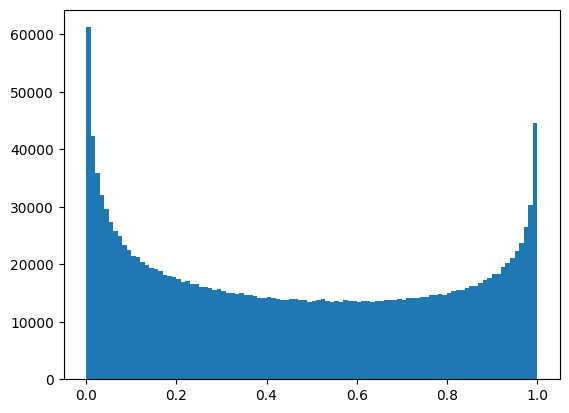

In [17]:
plt.hist(PS[:,1].flatten(), bins=100, range=(0,1))

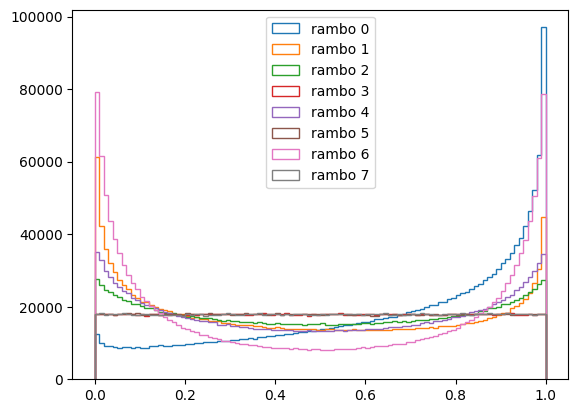

In [18]:
for i in range(8):
    plt.hist(PS[:,i].flatten(), bins=100, range=(0,1), label=f"rambo {i}", histtype="step")
plt.legend()

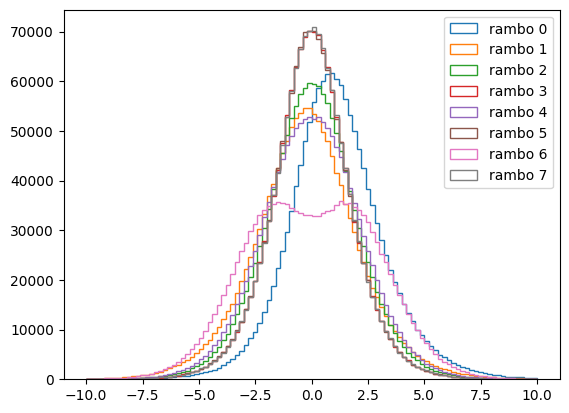

In [31]:
for i in range(8):
    plt.hist(PS_logit[:,i].flatten(), bins=100, range=(-10,10), label=f"rambo {i}", histtype="step")
plt.legend()

## Rescaling to std

In [33]:
PS_mean = PS_logit.nanmean(0)
PS_std = torch.sqrt(torch.nanmean(torch.pow(PS_logit, 2), 0) - torch.pow(PS_mean,2))

In [34]:
PS_std

tensor([2.1550, 2.3867, 2.0445, 1.8149, 2.1940, 1.8161, 2.7921, 1.8160, 0.7062,
        0.7300])

In [44]:
torch.logit(torch.tensor(5e-5))

tensor(-9.9034)

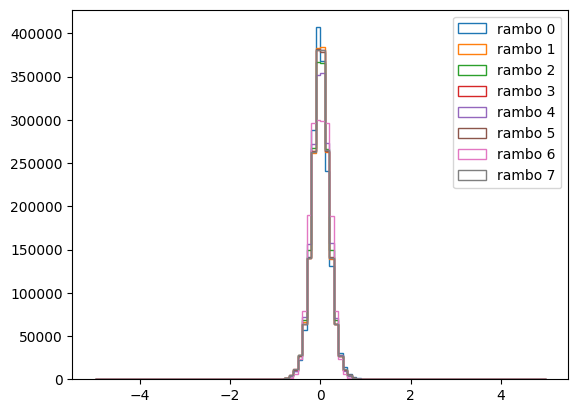

In [45]:
for i in range(8):
    plt.hist((PS_logit[:,i].flatten() - PS_mean[i])/(5*PS_std[i]), bins=100, range=(-5,5), label=f"rambo {i}", histtype="step")
plt.legend()

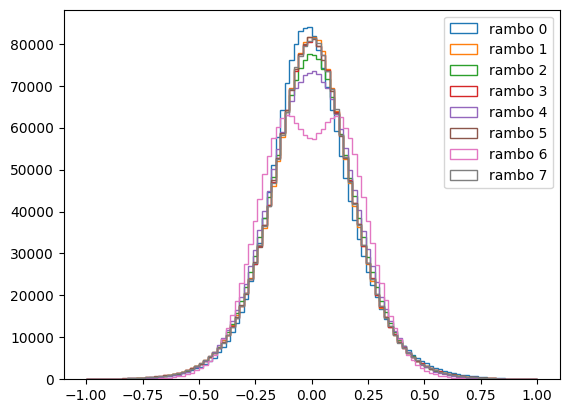

In [48]:
for i in range(8):
    plt.hist((PS_logit[:,i].flatten() - PS_mean[i])/(5*PS_std[i]), bins=100, range=(-1,1), label=f"rambo {i}", histtype="step")
plt.legend()

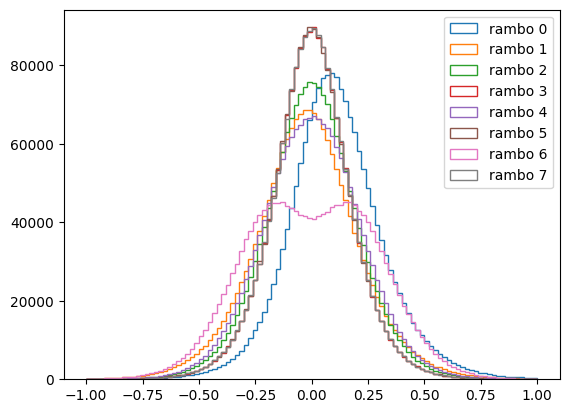

In [47]:
for i in range(8):
    plt.hist(PS_logit[:,i].flatten()/10, bins=100, range=(-1,1), label=f"rambo {i}", histtype="step")
plt.legend()

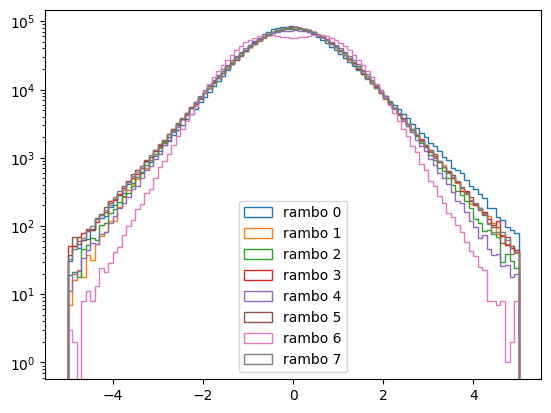

In [38]:
for i in range(8):
    plt.hist((PS_logit[:,i].flatten() - PS_mean[i])/PS_std[i], bins=100, range=(-5,5), label=f"rambo {i}", histtype="step")
plt.yscale("log")
plt.legend()

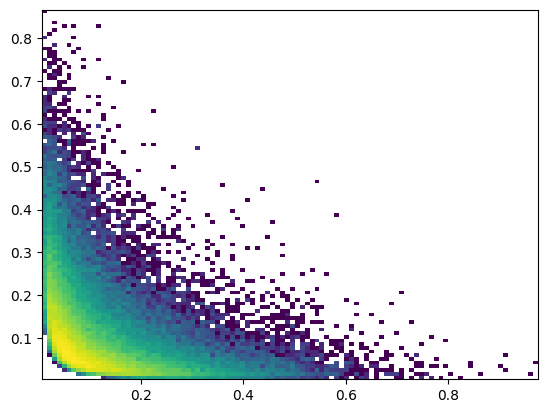

In [117]:
plt.hist2d(df.x1.cpu().numpy(), 
           df.x2.cpu().numpy(),
           bins=(100), norm=LogNorm());

In [ ]:
plt.hist(

In [103]:
boost_parton = data.parton_data.data_boost

In [115]:
x1 = (boost_parton[:,0,0]+boost_parton[:,0,3])/E_CM
x2 = (boost_parton[:,0,0]-boost_parton[:,0,3])/E_CM

df["x1"] = x1[:76800].cpu().numpy()
df["x2"] = x2[:76800].cpu().numpy()

In [116]:
df.x1

tensor([0.1389, 0.3194, 0.0215,  ..., 0.3626, 0.2612, 0.1042], device='cuda:0')